In [ ]:
# Important note: this code performs grid search for hyperparameters of the topic model.
# The code is not optimized for speed, and it may take a long time to run (>25 hours).
# The code is provided for reproducibility purposes only.

save = False
if save:
    import sys
    print(sys.executable)
    import numpy as np
    from scipy.stats import entropy, spearmanr
    import scipy.spatial.distance as scist
    import csv
    import pandas as pd
    import konlpy
    nlp_tagger = konlpy.tag.Okt()

    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.decomposition import LatentDirichletAllocation

    subjects =  ['sub-EZ9NM','sub-TV7EF','sub-WLC4O','sub-3L109','sub-3UYSS','sub-JVPPA','sub-EDOP8',
                 'sub-TIJD1','sub-AYDLR','sub-98UT7','sub-4G9A5','sub-YJBI8','sub-FG8PD','sub-BBN4K',
                 'sub-F61IR','sub-M1ZRL','sub-NZJZN','sub-XZ9SS','sub-L05R3','sub-ZOVPY','sub-6PEOF',
                 'sub-G6RPG','sub-TPNCU','sub-9ADGJ','sub-27IXQ','sub-NDX5S','sub-OE7EZ','sub-28E84',
                 'sub-ENN9N','sub-28OBV','sub-8WJAP','sub-SPHBN','sub-WP8SX','sub-BG4CW','sub-AVQEZ',
                 'sub-YLWD1','sub-0A4MV','sub-8PIML','sub-4T7NM','sub-X5RE0','sub-RUQON','sub-JVT46',
                 'sub-RTFX9','sub-OWWAF','sub-IC2KG','sub-S3I4J','sub-XFQA1','sub-UKF5L','sub-Z0MJJ',
                 'sub-9HMVR','sub-DBQ8H','sub-NAD3W','sub-KH33B','sub-JASQ6','sub-T6FHZ','sub-PQ8JD',
                 'sub-NOVID','sub-XAKBX','sub-JVSIQ','sub-D1FKN','sub-R3JA3','sub-GPMCX','sub-H8QL5',
                 'sub-6HW3V','sub-WF939']

    event_segmentation = pd.read_csv('utils/movie_event_segmentation.csv')

    n_events = len(event_segmentation)
    event_times = []
    for event in range(n_events):
        event_times.append(np.arange(event_segmentation['on time'][event], event_segmentation['off time'][event], 2))

    event_dict = {}
    for event in range(n_events):
        for time in event_times[event]:
            event_dict[time] = event

    event_words = {}
    for event in range(n_events):
        event_words[event] = []

    for event in range(n_events):
        try:
            for word in event_segmentation['dictionary'][event].split():
                event_words[event].append(word)
        except:
            pass

    movie_user_dictionary = pd.read_csv('utils/movie_user_dictionary.csv')
    user_dictionary = {}
    before_words = []
    for i in range(len(movie_user_dictionary)):
        before_word = movie_user_dictionary['before'][i]
        after_word = movie_user_dictionary['after'][i]
        user_dictionary[before_word] = after_word
        before_words.append(before_word)

    window_size_ref_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    num_topic_list = [10, 20, 30, 40, 50, 60, 70, 80]
    window_size_recall_list = [0, 1, 2, 3, 4, 5, 6]
    threshold_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    num_iterations = 50
    eta = 10e-5

    amount_optim_matrix = np.zeros((len(window_size_ref_list),
                                    len(num_topic_list),
                                    len(subjects),
                                    len(window_size_recall_list),
                                    len(threshold_list),
                                    num_iterations))

    temporal_optim_matrix = np.zeros((len(window_size_ref_list),
                                      len(num_topic_list),
                                      len(subjects),
                                      len(window_size_recall_list),
                                      len(threshold_list),
                                      num_iterations))

    total_number_of_calculation = temporal_optim_matrix.size
    print(total_number_of_calculation)
    calculation_counter = 0

    movie_annotation = 'utils/movie_korean_annotation.csv'
    passed_pos = ['Noun', 'Verb']
    num_cols=4

    ref_words = []
    with open(movie_annotation, 'r', encoding="utf-8") as csvFile:
        reader = csv.reader(csvFile)
        for row in reader:
            data = []
            current_event = event_dict[int(row[0])]
            for col in range(num_cols):
                for word, pos in nlp_tagger.pos(row[2+col], stem=True):
                    if pos in passed_pos:
                        data.append(word)
            ref_words.append(' '.join([word for word in data] + event_words[current_event]))

    for wref, window_size_ref in enumerate(window_size_ref_list):
        ref_words_ngram = []
        for i in range(len(ref_words)):
            if i < window_size_ref:
                ref_words_ngram.append(' '.join(ref_words[0:i + window_size_ref+1]))
            else:
                ref_words_ngram.append(' '.join(ref_words[i-window_size_ref:i + window_size_ref+1]))
        mrbean_ref = np.array(ref_words_ngram)

        np.random.seed(0) #for reproducibility
        for to, num_topic in enumerate(num_topic_list):
            for seed in range(num_iterations):
                countvector_model = CountVectorizer().fit(mrbean_ref)
                lda_model = LatentDirichletAllocation(n_components=num_topic,
                                                      learning_method='batch')
                lda_model.fit(countvector_model.transform(mrbean_ref))

                ref_model = lda_model.transform(countvector_model.transform(mrbean_ref))
                ref_pd = np.nansum((1 - scist.cdist(ref_model, ref_model, 'cosine')), axis=1)

                for sub, fname in enumerate(subjects):
                    recall_fname = f'utils/behavioral_data/{fname}_recall.txt'
                    recall_words = []
                    recall_sents = []
                    with open(recall_fname, 'r', encoding='utf-8') as file:
                        for line in file.readlines():
                            bow = []
                            for word, pos in nlp_tagger.pos(line, stem=True):
                                if pos in passed_pos:
                                    if word in before_words:
                                        bow.append(user_dictionary[word])
                                        recall_words.append(user_dictionary[word])
                                    else:
                                        bow.append(word)
                                        recall_words.append(word)
                            recall_sents.append(' '.join([word for word in bow]))

                    for wrec, window_size_recall in enumerate(window_size_recall_list):
                        mrbean_recall = []
                        for i in range(len(recall_sents)):
                            if i < window_size_recall:
                                mrbean_recall.append(' '.join(recall_sents[0:i + window_size_recall+1]))
                            else:
                                mrbean_recall.append(' '.join(recall_sents[i-window_size_recall:i + window_size_recall+1]))

                        recall_model = lda_model.transform(countvector_model.transform(mrbean_recall))

                        recall_acc = (1 - scist.cdist(ref_model, recall_model, 'cosine'))

                        for th, threshold in enumerate(threshold_list):
                            recall_acc_threshold = np.zeros(recall_acc.shape)
                            recall_acc_threshold[recall_acc>threshold] = recall_acc[recall_acc>threshold]

                            x_array = np.where((recall_acc>threshold)==1)[0]
                            y_array = np.where((recall_acc>threshold)==1)[1]
                            recall_pd = np.nansum(recall_acc_threshold, axis=1)
                            amount_score = 1/(1+entropy(ref_pd+eta, recall_pd+eta))
                            temporal_score = spearmanr(x_array,y_array)[0]

                            amount_optim_matrix[wref, to, sub, wrec, th, seed] = amount_score
                            temporal_optim_matrix[wref, to, sub,wrec, th, seed] = temporal_score

                            if calculation_counter % 10000 == 0:
                                print(f'***current_loop*** : {calculation_counter/total_number_of_calculation:0.3f}')
                            calculation_counter += 1

    np.save('_DATA/content_score_all_hyperparameters.npy', amount_optim_matrix)
    np.save('_DATA/ordering_score_all_hyperparameters.npy', temporal_optim_matrix)

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore, pearsonr, sem, spearmanr

window_size_ref_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
num_topic_list = [10, 20, 30, 40, 50, 60, 70, 80]
window_size_recall_list = [0, 1, 2, 3, 4, 5, 6]
threshold_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
num_iterations = 50
eta = 10e-5

content_score_model = np.mean(np.load('_DATA/content_score_all_hyperparameters.npy'), axis=-1)
ordering_score_model = np.mean(np.load('_DATA/ordering_score_all_hyperparameters.npy'), axis=-1)
print(content_score_model.shape, ordering_score_model.shape)

content_score = np.load("_DATA/content_score.npy")
ordering_score = np.load("_DATA/ordering_score.npy")

(11, 8, 65, 7, 7) (11, 8, 65, 7, 7)


In [62]:
import pandas as pd
from scipy.stats import spearmanr

subjects =  ['sub-EZ9NM','sub-TV7EF','sub-WLC4O','sub-3L109','sub-3UYSS','sub-JVPPA','sub-EDOP8',
             'sub-TIJD1','sub-AYDLR','sub-98UT7','sub-4G9A5','sub-YJBI8','sub-FG8PD','sub-BBN4K',
             'sub-F61IR','sub-M1ZRL','sub-NZJZN','sub-XZ9SS','sub-L05R3','sub-ZOVPY','sub-6PEOF',
             'sub-G6RPG','sub-TPNCU','sub-9ADGJ','sub-27IXQ','sub-NDX5S','sub-OE7EZ','sub-28E84',
             'sub-ENN9N','sub-28OBV','sub-8WJAP','sub-SPHBN','sub-WP8SX','sub-BG4CW','sub-AVQEZ',
             'sub-YLWD1','sub-0A4MV','sub-8PIML','sub-4T7NM','sub-X5RE0','sub-RUQON','sub-JVT46',
             'sub-RTFX9','sub-OWWAF','sub-IC2KG','sub-S3I4J','sub-XFQA1','sub-UKF5L','sub-Z0MJJ',
             'sub-9HMVR','sub-DBQ8H','sub-NAD3W','sub-KH33B','sub-JASQ6','sub-T6FHZ','sub-PQ8JD',
             'sub-NOVID','sub-XAKBX','sub-JVSIQ','sub-D1FKN','sub-R3JA3','sub-GPMCX','sub-H8QL5',
             'sub-6HW3V','sub-WF939']

human_rating_1 = pd.read_excel('utils/score_rating_human_rater_1.xlsx')
n_human_labeled_events_1 = 46
ordering_score_hand_1 = []
content_score_hand_1 = []
for i, fname in enumerate(subjects):
    try: # check errors
        label = np.array(human_rating_1[fname])
        n_events_recalled = n_human_labeled_events_1-np.sum(np.isnan(label))
        order_events_recalled = np.argsort(label)[:n_events_recalled]
        r, p = spearmanr(order_events_recalled, np.arange(n_events_recalled))
        ordering_score_hand_1.append(r)
        content_score_hand_1.append(n_events_recalled/n_human_labeled_events_1)
    except:
        print(fname)

ordering_score_hand_1 = np.array(ordering_score_hand_1)
content_score_hand_1 = np.array(content_score_hand_1)

human_rating_2 = pd.read_excel('utils/score_rating_human_rater_2.xlsx')
n_human_labeled_events_2 = 25
ordering_score_hand_2 = []
content_score_hand_2 = []
for i, fname in enumerate(subjects):
    try: # check errors
        label = np.array(human_rating_2[fname])
        n_events_recalled = n_human_labeled_events_2-np.sum(np.isnan(label))
        order_events_recalled = np.argsort(label)[:n_events_recalled]
        r, p = spearmanr(order_events_recalled, np.arange(n_events_recalled))
        ordering_score_hand_2.append(r)
        content_score_hand_2.append(n_events_recalled/n_human_labeled_events_2)
    except:
        print(fname)

ordering_score_hand_2 = np.array(ordering_score_hand_2)
content_score_hand_2 = np.array(content_score_hand_2)

In [63]:
ordering_score_hand = (ordering_score_hand_1 + ordering_score_hand_2) / 2
content_score_hand = (content_score_hand_1 + content_score_hand_2) / 2

ordering_score_similarity_to_hand = np.zeros((len(window_size_ref_list),
                                              len(num_topic_list),
                                              len(window_size_recall_list),
                                              len(threshold_list)))

content_score_similarity_to_hand = np.zeros((len(window_size_ref_list),
                                              len(num_topic_list),
                                              len(window_size_recall_list),
                                              len(threshold_list)))

for wref, window_size_ref in enumerate(window_size_ref_list):
    for to, num_topic in enumerate(num_topic_list):
        for wrec, window_size_recall in enumerate(window_size_recall_list):
            for th, threshold in enumerate(threshold_list):
                tmp_content_score_model = np.copy(content_score_model[wref, to, :, wrec, th])
                tmp_ordering_score_model = np.copy(ordering_score_model[wref, to, :, wrec, th])
                if np.any(np.isnan(tmp_content_score_model)) or np.any(np.isnan(tmp_ordering_score_model)):
                    continue
                ordering_r = pearsonr(ordering_score_hand, tmp_ordering_score_model)[0]
                content_r = pearsonr(content_score_hand, tmp_content_score_model)[0]
                ordering_score_similarity_to_hand[wref, to, wrec, th] = ordering_r
                content_score_similarity_to_hand[wref, to, wrec, th] = content_r

In [64]:
hyperparameters = np.unravel_index(np.argmax(content_score_similarity_to_hand + ordering_score_similarity_to_hand),
                                   content_score_similarity_to_hand.shape)
print('ref window:', window_size_ref_list[hyperparameters[0]])
print('topic number:', num_topic_list[hyperparameters[1]])
print('recall window:', window_size_recall_list[hyperparameters[2]])
print('threshold number:', threshold_list[hyperparameters[3]])

content_score_optimized = content_score_model[hyperparameters[0],
                          hyperparameters[1], :,
                          hyperparameters[2],
                          hyperparameters[3]]
ordering_score_optimized = ordering_score_model[hyperparameters[0],
                           hyperparameters[1], :,
                           hyperparameters[2],
                           hyperparameters[3]]

print(np.allclose(content_score, content_score_optimized))
print(np.allclose(ordering_score, ordering_score_optimized))

ref window: 0
topic number: 80
recall window: 0
threshold number: 0.3
True
True


PearsonRResult(statistic=0.8997926556670903, pvalue=2.251271086395903e-24)
PearsonRResult(statistic=0.7682817455592065, pvalue=8.028245563745915e-14)
PearsonRResult(statistic=0.9001219288436346, pvalue=2.0399494546624074e-24)
PearsonRResult(statistic=0.6186385442428419, pvalue=3.9741458093705354e-08)


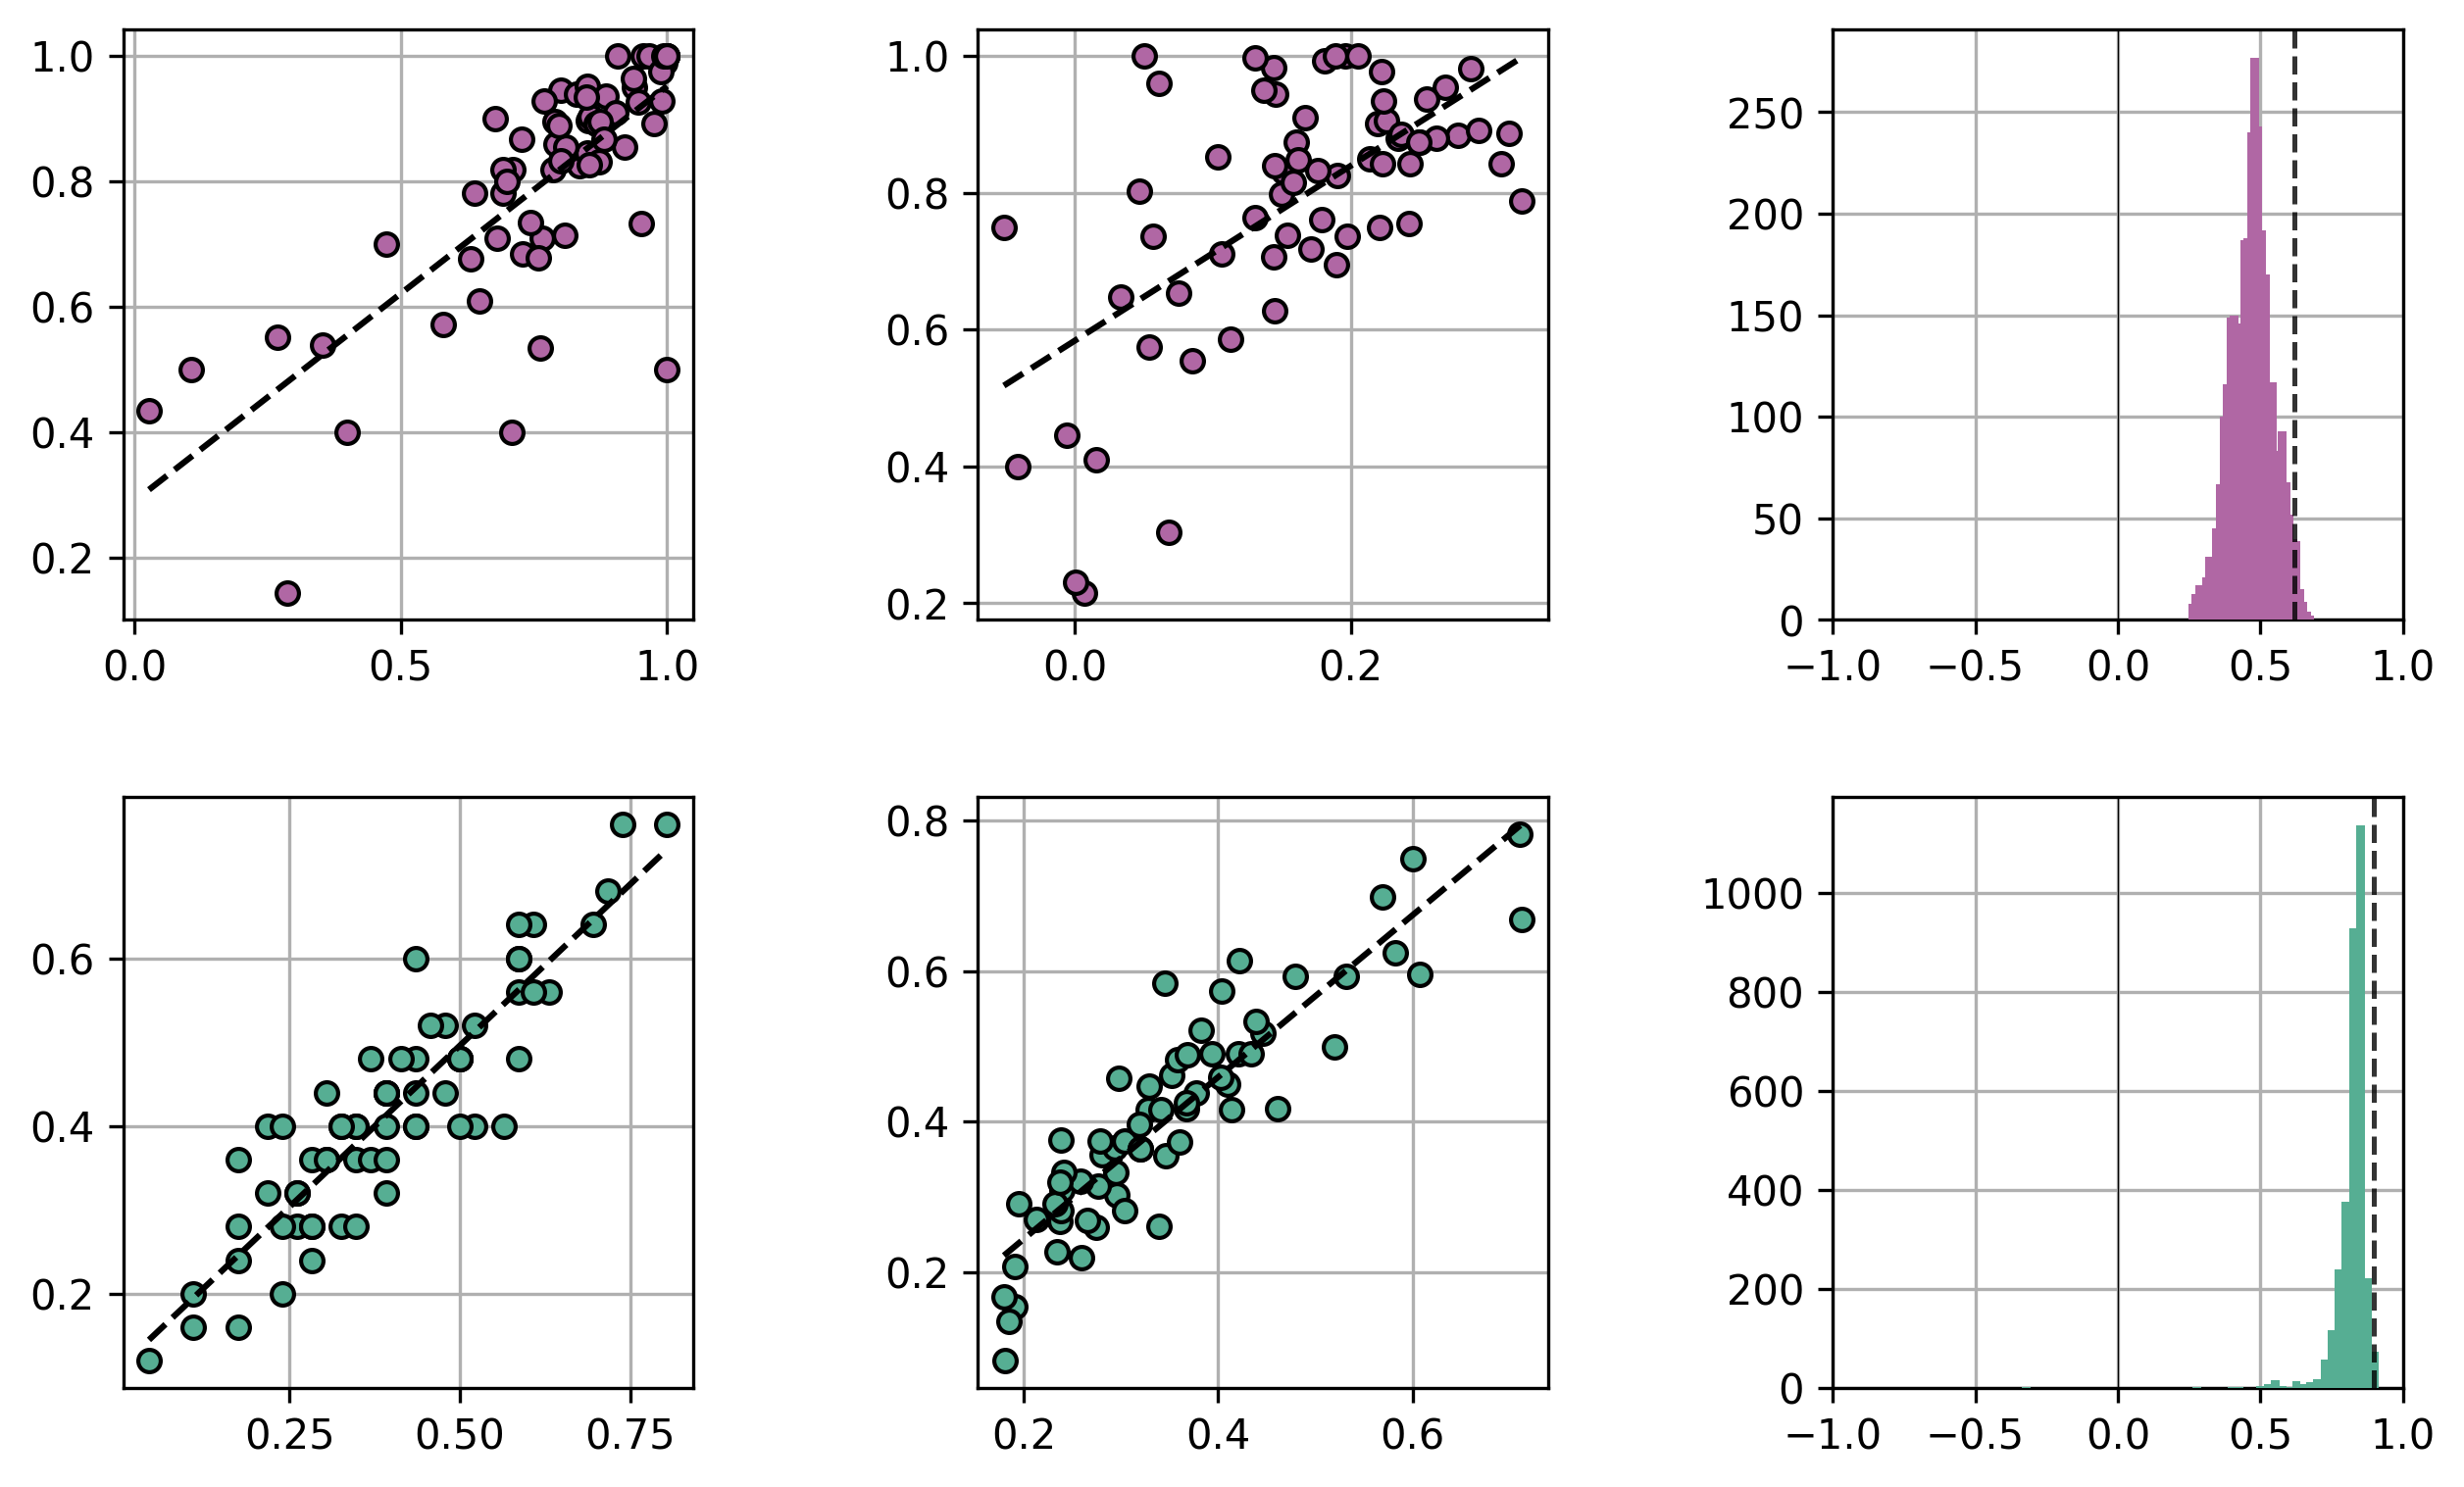

In [65]:
from scipy.stats import linregress

nonzero_content_similarity = content_score_similarity_to_hand.ravel()[content_score_similarity_to_hand.ravel()!=0.0]
nonzero_ordering_similarity = ordering_score_similarity_to_hand.ravel()[ordering_score_similarity_to_hand.ravel()!=0.0]
plt.style.use('default')
fig, axes = plt.subplots(2,3, figsize=(10,6), dpi=300)

x = content_score_hand_1
y = content_score_hand_2
axes[1,0].scatter(x, y, s=30, c='#56AE93', edgecolors='k', zorder=100)
slope, intercept, r, p, stderr = linregress(x, y)
x_range = np.array([np.min(x), np.max(x)])
axes[1,0].plot(x_range, intercept + slope * x_range, 'k--', label='r={:0.3f}, p={:0.3f}'.format(r, p), zorder=100)
print(pearsonr(x,y))

x = ordering_score_hand_1
y = ordering_score_hand_2
axes[0,0].scatter(x, y, s=30, c='#B067A4', edgecolors='k', zorder=100)
slope, intercept, r, p, stderr = linregress(x, y)
x_range = np.array([np.min(x), np.max(x)])
axes[0,0].plot(x_range, intercept + slope * x_range, 'k--', label='r={:0.3f}, p={:0.3f}'.format(r, p), zorder=100)
print(pearsonr(x,y))


content_score_optimized = content_score_model[hyperparameters[0], hyperparameters[1], :, hyperparameters[2], hyperparameters[3]]
ordering_score_optimized = ordering_score_model[hyperparameters[0], hyperparameters[1], :, hyperparameters[2], hyperparameters[3]]

x = content_score_optimized
y = content_score_hand
axes[1,1].scatter(x, y, s=30, c='#56AE93', edgecolors='k', zorder=100)
slope, intercept, r, p, stderr = linregress(x, y)
x_range = np.array([np.min(x), np.max(x)])
axes[1,1].plot(x_range, intercept + slope * x_range, 'k--', label='r={:0.3f}, p={:0.3f}'.format(r, p), zorder=100)
print(pearsonr(x,y))

x = ordering_score_optimized
y = ordering_score_hand
axes[0,1].scatter(x, y, s=30, c='#B067A4', edgecolors='k', zorder=100)
slope, intercept, r, p, stderr = linregress(x, y)
x_range = np.array([np.min(x), np.max(x)])
axes[0,1].plot(x_range, intercept + slope * x_range, 'k--', label='r={:0.3f}, p={:0.3f}'.format(r, p), zorder=100)
print(pearsonr(x,y))

# Histogram 
axes[1,2].hist(content_score_similarity_to_hand.ravel()[content_score_similarity_to_hand.ravel()!=0.0],
               bins=50, color='#56AE93', width=0.03, zorder=100)
axes[1,2].axvline(0.9, c='k', lw=1.2, alpha=0.8, linestyle='--',
                label="Mean: {:0.3f}".format(np.mean(nonzero_content_similarity)), zorder=100)
axes[0,2].hist(ordering_score_similarity_to_hand.ravel()[ordering_score_similarity_to_hand.ravel()!=0.0],
               bins=35,color='#B067A4', width=0.03, zorder=100)
axes[0,2].axvline(0.618, c='k', lw=1.2, alpha=0.8, linestyle='--', zorder=100)
axes[1,2].set_xlim(-1.0, 1.0)
axes[1,2].axvline(0.0, c='k', lw=0.3)
axes[0,2].axvline(0.0, c='k', lw=0.3)
axes[0,2].set_xlim(-1.0, 1.0)
                  
for i in range(2):
    for j in range(3):
        axes[i,j].grid(True, zorder=0)

plt.subplots_adjust(wspace=0.5, hspace=0.3)